In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
'''
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''        

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"\nimport os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [1]:
!pip install torch torchvision transformers diffusers matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 32.7 MB/s eta 0:00:0000:010:01


In [2]:
# Import Libraries
import os
import requests
from PIL import Image
import matplotlib.pyplot as plt
import json
import torch
from torchvision import transforms

In [3]:
data_dir = "/kaggle/input/dataset-genai/imagic-editing.github.io-main/tedbench"

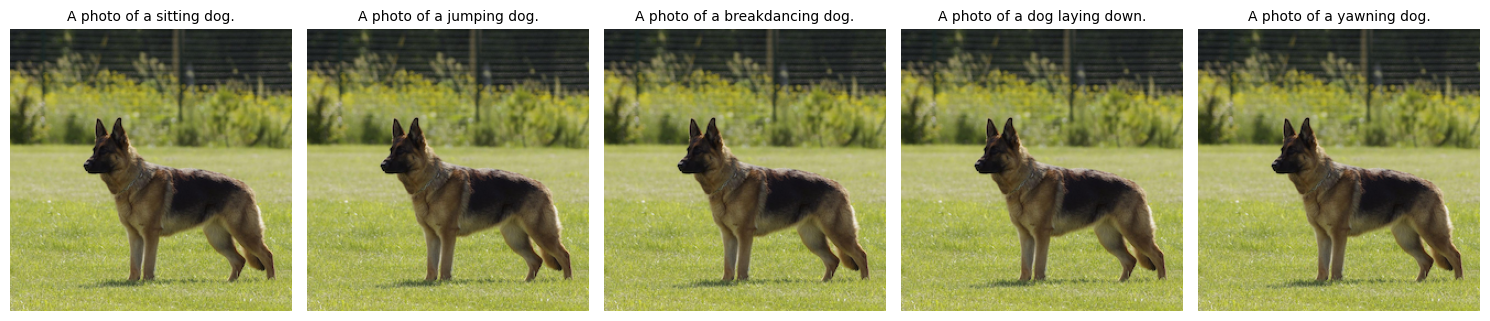

In [4]:
import json
import os
from PIL import Image
import matplotlib.pyplot as plt

# Paths to data
data_dir = "/kaggle/input/dataset-genai/imagic-editing.github.io-main/tedbench"
image_dir = os.path.join(data_dir, "originals")  # Path to images
json_file = os.path.join(data_dir, "input_list.json")  # JSON file path

# Load JSON annotations
def load_annotations(json_file):
    with open(json_file, 'r') as f:
        annotations = json.load(f)
    return annotations

# Visualize dataset
def visualize_dataset(annotations, image_dir, num_samples=5):
    plt.figure(figsize=(15, 5))
    
    for i in range(num_samples):
        # Get image and corresponding prompt
        annotation = annotations[i]
        img_name = annotation['img_name']
        target_text = annotation['target_text']
        
        # Load the image
        img_path = os.path.join(image_dir, img_name)
        if os.path.exists(img_path):
            img = Image.open(img_path)
            
            # Plot the image with the prompt
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(target_text, fontsize=10)
        else:
            print(f"Image not found: {img_path}")
    
    plt.tight_layout()
    plt.show()

# Load and visualize
annotations = load_annotations(json_file)
visualize_dataset(annotations, image_dir, num_samples=5)


In [6]:
#### STEP 1 TEXT EMBEDDING OPTIMIZATION

## Initialize Models 

from transformers import CLIPProcessor, CLIPModel
import torch

# Load CLIP model
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Freeze the CLIP model during optimization
for param in clip_model.parameters():
    param.requires_grad = False

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [7]:
## Encode the Input Image and Target Text Prompt
  
image_embedding_list = []
text_embedding_list = []
num_samples = 5

for i in range(num_samples):
    # Get image and corresponding prompt
    annotation = annotations[i]
    img_name = annotation['img_name']
    target_text = annotation['target_text']
        
    # Load the image
    img_path = os.path.join(image_dir, img_name)
    if os.path.exists(img_path):
        img = Image.open(img_path)
        inputs = processor(images=img, return_tensors="pt")
        # Extract image embedding
        with torch.no_grad():
            image_embedding = clip_model.get_image_features(**inputs)
            image_embedding = image_embedding / image_embedding.norm(dim=-1, keepdim=True)  # Normalize
            image_embedding_list.append(image_embedding)
    
        text_inputs = processor(text=[target_text], return_tensors="pt", padding=True)
        with torch.no_grad():
            e_tgt = clip_model.get_text_features(**text_inputs)
            e_tgt = e_tgt / e_tgt.norm(dim=-1, keepdim=True)  # Normalize

        # Initialize e_opt as a clone of e_tgt
        e_opt = e_tgt.clone().detach().requires_grad_(True)

        # Optimizer and loss function
        optimizer = torch.optim.Adam([e_opt], lr=1e-3) 
        loss_fn = torch.nn.MSELoss()

        # Optimization loop
        num_steps = 100

        for step in range(num_steps):
             optimizer.zero_grad()
             # Compute loss between e_opt and image embedding
             loss = loss_fn(e_opt, image_embedding)
             loss.backward()
             optimizer.step()
    
             if step % 10 == 0:
                 print(f"Step {step}: Loss = {loss.item()}")
                       
        text_embedding_list.append(e_opt)
        print("Optimization complete. e_opt is ready for fine-tuning.")

Step 0: Loss = 0.002900863066315651
Step 10: Loss = 0.0023312862031161785
Step 20: Loss = 0.0019330852665007114
Step 30: Loss = 0.0016552198212593794
Step 40: Loss = 0.001455701538361609
Step 50: Loss = 0.0013069974957033992
Step 60: Loss = 0.0011911789188161492
Step 70: Loss = 0.0010971095180138946
Step 80: Loss = 0.0010179247474297881
Step 90: Loss = 0.0009493828401900828
Optimization complete. e_opt is ready for fine-tuning.
Step 0: Loss = 0.0029583785217255354
Step 10: Loss = 0.0023860468063503504
Step 20: Loss = 0.00197730609215796
Step 30: Loss = 0.0016843148041516542
Step 40: Loss = 0.001469503971748054
Step 50: Loss = 0.001307243830524385
Step 60: Loss = 0.0011804132955148816
Step 70: Loss = 0.0010778966825455427
Step 80: Loss = 0.0009924499318003654
Step 90: Loss = 0.0009193568839691579
Optimization complete. e_opt is ready for fine-tuning.
Step 0: Loss = 0.0030729365535080433
Step 10: Loss = 0.002452283399179578
Step 20: Loss = 0.0020011935848742723
Step 30: Loss = 0.00167609

In [7]:
## Verification by cosine similarity

for x in range(len(image_embedding_list)):
    similarity = torch.nn.functional.cosine_similarity(text_embedding_list[x], image_embedding_list[x])
    print(f"Cosine Similarity: {similarity.item()}")
    print()

Cosine Similarity: 0.7645783424377441

Cosine Similarity: 0.7675445079803467

Cosine Similarity: 0.7805993556976318

Cosine Similarity: 0.764941394329071

Cosine Similarity: 0.7889953851699829



In [9]:
!pip install diffusers transformers accelerate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached diffusers-0.31.0-py3-none-any.whl.metadata (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 35.3 MB/s eta 0:00:0000:0100:01


In [10]:
#### STEP 2  MODEL FINE TUNING

import torch
from torch.nn.functional import mse_loss
from torchvision import transforms
from PIL import Image
from torch.cuda.amp import autocast, GradScaler
from diffusers import StableDiffusionPipeline


# Check and set available GPUs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {num_gpus}")

# Load the pipeline
#pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4").to(device)

pipe = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1").to(device)

# Enable DataParallel for multi-GPU usage
#pipe.unet = torch.nn.DataParallel(pipe.unet)  # Distribute UNet across GPUs


# Enable gradient computation for fine-tuning
for param in pipe.unet.parameters():
    param.requires_grad = True

Using device: cuda
Number of GPUs available: 2


model_index.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/824 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/939 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [13]:
from torch import nn


projection_layer = nn.Linear(512, 768).to("cuda:0")

def adjust_embedding(optimized_embedding, target_length=77):
    """
    Adjust the optimized embedding to match the UNet input dimensions.
    """
    # Expand or truncate sequence length
    current_length = optimized_embedding.shape[1]
    if current_length < target_length:
        padding = torch.zeros(
            optimized_embedding.shape[0],
            target_length - current_length,
            optimized_embedding.shape[2],
            device=optimized_embedding.device
        )
        adjusted_embedding = torch.cat((optimized_embedding, padding), dim=1)
    else:
        adjusted_embedding = optimized_embedding[:, :target_length, :]

    # Check the feature dimension of the embedding
    if adjusted_embedding.shape[2] == 512:  # Apply projection if still in original dimension
        adjusted_embedding = projection_layer(adjusted_embedding)

    return adjusted_embedding


In [25]:
torch.cuda.is_available()

True

In [27]:
q = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
q

[<torch.cuda.device at 0x78873206ee30>, <torch.cuda.device at 0x78873206eb00>]

In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
pipe = torch.nn.DataParallel(pipe, device_ids = [0,1]).to(device)

In [14]:
print(f"Type of pipe.unet: {type(pipe.unet)}")
print(pipe.unet)

Type of pipe.unet: <class 'diffusers.models.unets.unet_2d_condition.UNet2DConditionModel'>
UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_feature

In [24]:
# Define the projection layer
projection_layer = nn.Linear(512, 768).to(device)

# Adjust embedding to match UNet input size
def adjust_embedding_1(optimized_embedding, target_length=77):
    current_length = optimized_embedding.shape[1]
    batch_size = optimized_embedding.shape[0]
    embedding_dim = optimized_embedding.shape[2]
    
    # Pad or truncate sequence length
    if current_length < target_length:
        padding = torch.zeros(batch_size, target_length - current_length, embedding_dim, device=optimized_embedding.device)
        adjusted_embedding = torch.cat((optimized_embedding, padding), dim=1)
    else:
        adjusted_embedding = optimized_embedding[:, :target_length, :]
    
    # Apply the projection if needed
    if adjusted_embedding.shape[2] == 512:
        adjusted_embedding = projection_layer(adjusted_embedding)

    return adjusted_embedding

In [24]:
from diffusers import StableDiffusionPipeline

# Load the pipeline
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")

# Disable the safety checker
pipe.safety_checker = None  # Disable NSFW filter

# Move pipeline to the correct device
pipe.to("cuda")

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.31.0",
  "_name_or_path": "runwayml/stable-diffusion-v1-5",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

/tmp/ipykernel_30/4138135544.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/50 [00:00<?, ?it/s]

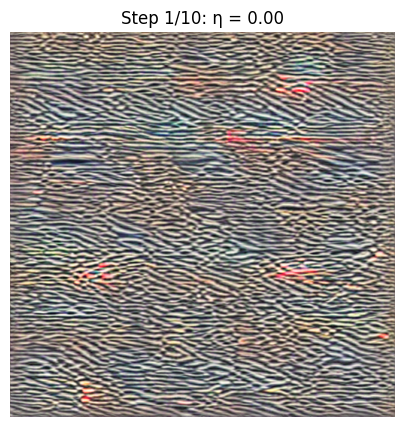

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [25]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
import os
import time
from diffusers.pipelines.stable_diffusion import StableDiffusionPipelineOutput


# Create a directory to save the images (optional)
output_dir = "interpolation_progress"
os.makedirs(output_dir, exist_ok=True)

# Define the range of eta values for interpolation
eta_values = torch.linspace(0, 1, steps=10).to(device)  # 10 steps from 0 to 1

# Initialize the projection layer if shapes are mismatched
projection_layer = nn.Linear(512, 768).to(device)  # Adjust dimensions

e_tgt = e_tgt.to(device)
e_tgt_projected = projection_layer(e_tgt)


# Setup for live visualization
plt.ion()  # Turn on interactive mode
fig, ax = plt.subplots(figsize=(5, 5))

# Interpolation loop with live visualization
for i, eta in enumerate(eta_values):
    # Interpolate embeddings
    e_interpolated = eta * e_tgt_projected + (1 - eta) * e_opt
    e_interpolated = e_interpolated.to(device)

    # Generate image using the interpolated embedding
    with torch.no_grad():
        with torch.cuda.amp.autocast():
            generated_image: StableDiffusionPipelineOutput = pipe(
                    prompt_embeds=e_interpolated,  # Pass the embedding as prompt_embeds
                    height=512,  # Set desired output image height
                    width=512,   # Set desired output image width
                    num_inference_steps=50,  # Number of denoising steps
                    guidance_scale=7.5,  # CFG scale
                    output_type="pil",  # Output image format
                    ).images[0]

    # Convert the generated image to a PIL image
    pil_image = generated_image

    # Save the image (optional)
    pil_image.save(os.path.join(output_dir, f"step_{i}.png"))

    # Update the live plot
    ax.clear()
    ax.imshow(pil_image)
    ax.axis("off")
    ax.set_title(f"Step {i+1}/{len(eta_values)}: η = {eta:.2f}")
    plt.pause(0.1)  # Pause briefly to update the display

# Turn off interactive mode after loop
plt.ioff()
plt.show()


decoded_image


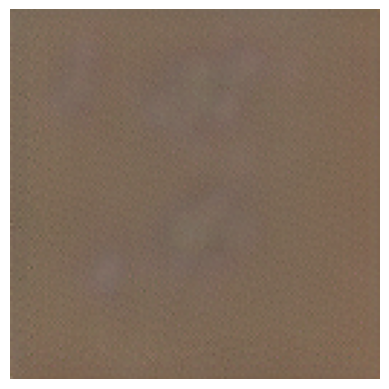

encoded_image


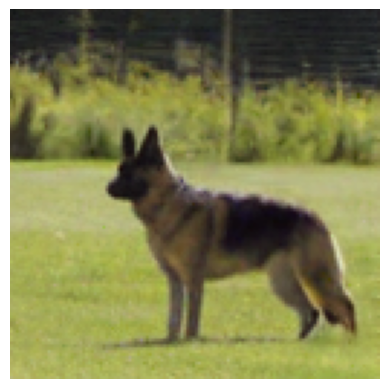

In [32]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

# Assuming `generated_latents` is the output latent tensor
with torch.no_grad():
    # Ensure the latent tensor is on the same device and in the correct data type
    generated_latents = generated_latents.to(device).float()  # Convert to float32

    # Decode the latents into image tensors
    decoded_image_output = pipe.vae.decode(generated_latents)
    decoded_image_tensor = decoded_image_output.sample  # Extract the tensor from DecoderOutput

# Normalize latents to pixel value range [0, 1]
decoded_image_tensor = (decoded_image_tensor + 1.0) / 2.0
decoded_image_tensor = decoded_image_tensor.clamp(0, 1)  # Clamp values

# Convert the tensor to a PIL image for visualization
decoded_image = to_pil_image(decoded_image_tensor[0].cpu())  # Move to CPU for PIL compatibility

# Display the image
print('decoded_image')
plt.imshow(decoded_image)
plt.axis("off")
plt.show()


import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

# Assuming `generated_latents` is the output latent tensor
with torch.no_grad():
    # Ensure the latent tensor is on the same device and in the correct data type
    latent_input_image = latent_input_image.to(device).float()  # Convert to float32

    # Decode the latents into image tensors
    decoded_image_output = pipe.vae.decode(latent_input_image)
    decoded_image_tensor = decoded_image_output.sample  # Extract the tensor from DecoderOutput

# Normalize latents to pixel value range [0, 1]
decoded_image_tensor = (decoded_image_tensor + 1.0) / 2.0
decoded_image_tensor = decoded_image_tensor.clamp(0, 1)  # Clamp values

# Convert the tensor to a PIL image for visualization
decoded_image = to_pil_image(decoded_image_tensor[0].cpu())  # Move to CPU for PIL compatibility

# Display the image
print('encoded_image')
plt.imshow(decoded_image)
plt.axis("off")
plt.show()


In [ ]:
import os
import torch
from torch import nn
from torch.nn.functional import mse_loss
from torch.cuda.amp import autocast, GradScaler
from diffusers import StableDiffusionPipeline
from torchvision import transforms
from PIL import Image
from torch.utils.checkpoint import checkpoint
from transformers import CLIPTextModel, CLIPTokenizer

# Define device
device = "cuda:0"

# Load the pipeline from HuggingFace's diffusers
model_name = "stabilityai/stable-diffusion-2-1"
pipe = StableDiffusionPipeline.from_pretrained(model_name).to(device)

# Define the projection layer for embedding adjustment
projection_layer = nn.Linear(512, 768).to(device)

# Adjust embedding to match UNet input size
def adjust_embedding_1(optimized_embedding, target_length=77):
    current_length = optimized_embedding.shape[1]
    batch_size = optimized_embedding.shape[0]
    embedding_dim = optimized_embedding.shape[2]
    
    # Pad or truncate sequence length
    if current_length < target_length:
        padding = torch.zeros(batch_size, target_length - current_length, embedding_dim, device=optimized_embedding.device)
        adjusted_embedding = torch.cat((optimized_embedding, padding), dim=1)
    else:
        adjusted_embedding = optimized_embedding[:, :target_length, :]
    
    # Apply the projection if needed
    if adjusted_embedding.shape[2] == 512:
        adjusted_embedding = projection_layer(adjusted_embedding)

    return adjusted_embedding

# Load and preprocess input image
img_path = "/kaggle/input/dataset-genai/imagic-editing.github.io-main/tedbench/originals/dog2_standing.png"  # Path to input image
input_image = Image.open(img_path).convert("RGB")

preprocess = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize to 512x512
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize
])

input_image_tensor = preprocess(input_image).unsqueeze(0).to(device).float()

# Tokenizer setup for the text embedding
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_model = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14").to(device)

# Assuming `text_embedding_list` and `annotations` are defined
# Use the last text embedding (e_opt) from the list
e_opt = text_embedding_list[-1].unsqueeze(0).to(device)  # Last text embedding
annotation = annotations[-1]  # Assuming annotations contains image metadata
img_name = annotation['img_name']

# Optimizer setup for fine-tuning
optimizer = torch.optim.Adam(pipe.unet.parameters(), lr=5e-6)
accumulation_steps = 1
scaler = GradScaler()

# Fine-tuning loop parameters
num_epochs = 1
num_steps = 150

for epoch in range(num_epochs):
    optimizer.zero_grad()
    for step in range(num_steps):
        # VAE encoding step (to get latents)
        latent_input_image = pipe.vae.encode(input_image_tensor).latent_dist.sample().to(device)

        # Simulate larger batch size with gradient accumulation
        latents = torch.randn_like(latent_input_image).to(device)

        # Generate noisy latents
        timesteps = torch.tensor([step]).to(device)
        noise = torch.randn_like(latents).to(device)
        noisy_latents = pipe.scheduler.add_noise(latents, noise, timesteps).to(device)

        print("Shape of noisy_latents:", noisy_latents.shape)
        print("Shape of timesteps:", timesteps.shape)
        print("Shape of e_opt before adjustment:", e_opt.shape)

        # Adjust embedding shape
        #e_opt = adjust_embedding_1(e_opt)
        e_opt = e_opt.to(device)
        e_opt = torch.nn.Linear(512, 768)(e_opt).to(device)

        # Use autocast for mixed precision in UNet
        with autocast(True):
            def forward_pass(*inputs):
                return pipe.unet(*inputs)["sample"]

            # Generate latents using the optimized text embedding (e_opt)
            generated_latents = checkpoint(forward_pass, noisy_latents, timesteps, e_opt)

            # Compute the reconstruction loss
            loss = mse_loss(generated_latents, latent_input_image)

        # Scale loss and perform backward pass with mixed precision
        scaler.scale(loss).backward(retain_graph=True)

        # Gradient accumulation
        if (step + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        # Periodically print loss
        if step % 50 == 0:
            print(f"Epoch {epoch}, Step {step}: Loss = {loss.item()}")

        # Free up unused memory
        del latents, noise, noisy_latents, generated_latents
        torch.cuda.empty_cache()

    print(f"Epoch {epoch} completed.")

print("Fine-tuning complete!")
